In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import linalg as la

plt.ion()
import matplotlib as mpl

#plt.close('all')

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.markeredgewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 14

nx = 100
ny = 50

Lx = 4
Ly = 2

shape = (ny, nx)
dx = Lx/nx
dy = Ly/ny

xc = (np.arange(nx)+0.5)*dx
yc = (np.arange(ny)+0.5)*dy
print(np.shape(xc), np.shape(yc))
xxc, yyc = np.meshgrid(xc, yc)
print(np.shape(xxc),np.shape(yyc))
# define msk to have a circular domain 
#dtype = "b" signifie que l'on a les chiffres sur 1 bits, donc de 0 à 250
msk = np.ones(shape, dtype="b")
msk[((xxc-Lx/2)**2+(yyc-Ly/2)**2)>1] = 0
print(msk)


""""
#If you want to have the first domain, uncomment these lines below: 

msk = np.ones(shape, dtype="b")
msk[:ny//3, :nx//3] = 0
"""


N = msk.sum()
print("N=",N)


# define G
#G est là pour avoir des étiquettes des cellules 
G = np.zeros(ny*nx, dtype="i")
G[:] = -1
G[msk.flat>0] = np.arange(N)
G.shape = shape

j, i = np.where(msk == 1)

# define laplacian

# regular neighbours South,North,West,East
#here it's for the Ostrogradsky theorem...
neighbours = {
    (-1, 0): dx/dy,
    (1, 0): dx/dy,
    (0, -1): dy/dx,
    (0, 1): dy/dx
    }


data = np.zeros((5*N,))
rows = np.zeros((5*N,), dtype=int)
cols = np.zeros((5*N,), dtype=int)
count = 0

for k in range(N):
    nbneighb = 0
    #coef diagonaux
    cdiag = 0.
    #indices d'où se trouve la case k
    j0, i0 = j[k], i[k]
    #.items retourne l'entrée du dico et sa déf 
    for who, coef in neighbours.items():
        dj, di = who[0], who[1]
        j1 = j0+dj
        i1 = i0+di
        #condition dedans ou pas
        inside = ( (0 <= i1 < nx) and (0<= j1 < ny))
        # set the coefficient only if the neighbour is inside the grid
        if inside:
            #-1 is when there is solid, no fluid in the domain
            l = G[j1, i1]
            # and is interior
            if l > -1:
                #on créer notre matrice
                rows[count], cols[count], data[count] = k, l, coef
                #pour ajouter un nvel élément 
                count += 1
                nbneighb += coef
                cdiag -= coef
            else:
                #condition au limite phi=0 aux bords, c'est ici que le cas périodique va être définit
                cdiag -= 2*coef
        else:            
            cdiag -= 2*coef
        
    rows[count], cols[count], data[count] = k, k, cdiag
    count += 1
        
A = sparse.coo_matrix(
    (data[:count], (rows[:count], cols[:count])),
   shape=(N, N) ).tocsr()


if True:
    b = np.zeros((N,))
    b[N//5] = 1
    b[3*N//5] =-1
    b *= dx*dy
    x = la.spsolve(A, b)
    phi = np.zeros(shape)
    phi[G>-1] = x
    phi[G>-1] == np.nan
    plt.figure()
    plt.imshow(phi, origin="lower")
    plt.colorbar()
else:
    d2 = (xxc-Lx*.3)**2 + (yyc-Ly*.7)**2
    rhs = np.exp(-d2/(2*0.1**2))
    d2 = (xxc-Lx*.6)**2 + (yyc-Ly*.2)**2
    rhs -= np.exp(-d2/(2*0.1**2))

    b = rhs[G>-1]
    b *= dx*dy
    x = la.spsolve(A, b)
    phi = np.zeros(shape)
    phi[G>-1] = x
    phi[G==-1] = np.nan

    f2 = plt.figure()
    plt.contourf(xc,yc, phi, 20)
    plt.colorbar()
    #plt.tight_layout()
    plt.axis("equal")
    plt.axis([0, Lx, 0, Ly])
    plt.show()


(100,) (50,)
(50, 100) (50, 100)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
N= 1976


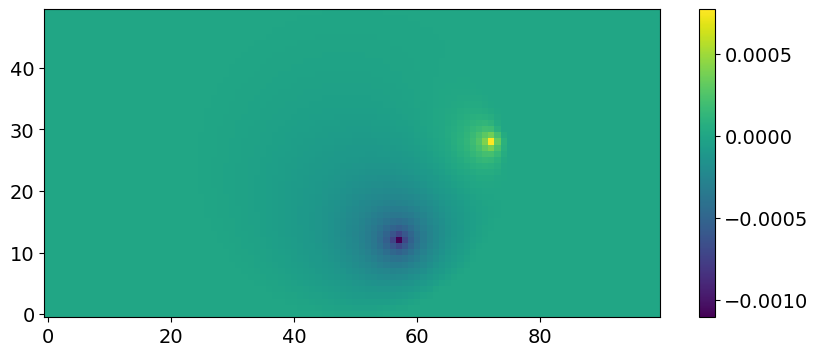

In [21]:
b = np.zeros((N,))
b[N//5] = 1
b[3*N//5] =-1
b *= dx*dy
x = la.spsolve(A, b)
phi = np.zeros(shape)
phi[G>-1] = x

plt.figure(figsize = (10,4))
plt.imshow(phi, origin="lower")
plt.colorbar()
plt.show()

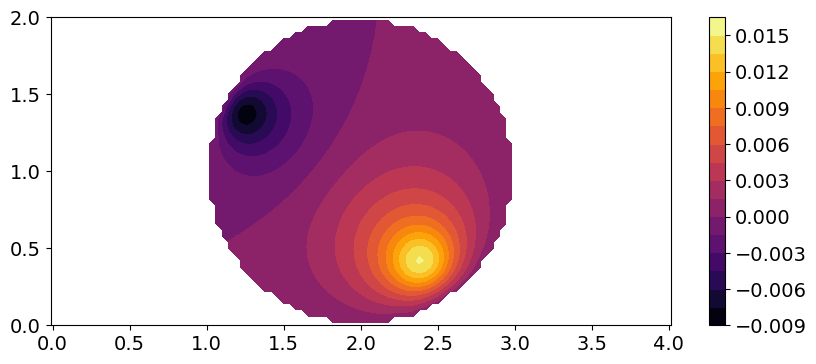

In [22]:
d2 = (xxc-Lx*.3)**2 + (yyc-Ly*.7)**2
rhs = np.exp(-d2/(2*0.1**2))
d2 = (xxc-Lx*.6)**2 + (yyc-Ly*.2)**2
rhs -= np.exp(-d2/(2*0.1**2))
b =  rhs[G>-1]
b *= dx*dy
x = la.spsolve(A, b)
phi = np.zeros(shape)
phi[G>-1] = x
phi[G==-1] = np.nan

plt.figure(figsize = (10,4))
plt.contourf(xc,yc, phi, 20,cmap = 'inferno')
plt.colorbar()
#plt.tight_layout()
plt.axis("equal")
plt.axis([0, Lx, 0, Ly])
plt.show()

### Bonus question for 13/10/21

* faire un domaine cylindrique/circulaire et afficher les modes du djambé
* traiter le cas périodique selon x, il faudra donc bien faire la connexion entre les colonnes x et x+dx si on a quelque chose de périodique en dx

adapter le calcul au cas $\nabla*(K(x,y)*\nabla(\phi) = f$ avec K le coefficient variable

Considérons le cas des ondes de gravité, en eaux peu profondes $\lambda>>H$ qui sont régies par l'équation : $\frac{\partial^2\eta}{dt^2} = \nabla[g*H*\nabla(\eta)]$

## Bonus = dynamique des points vortex
on créé 2 vortex de signes différents, on a donc un champ de vitesses qui part dans un direction. 
Si les 2 vortex sont de même signes, alors ils se tournent autour

On a donc l'ensemble qui créé une fonction de courant :

Considérons M points de vortex $x_i(t) et y_i(t)$ avec le paramètre $\Gamma = \iint {curlu*dxdy}$ on en déduit la fonction de courant $\Psi = \sum_i {\Gamma_i * \delta(x-x_i , y-y_i)}$

On définit la vitesse : $v_i = \nabla * \Psi$

On a avec la fontcion de courant : $v_i^x = - \frac{\partial\Psi}{dy}$
                                    $v_i^y = \frac{\partial\Psi}{dx}  $

On a les equations et on injecte des ondes planes du type : 
$\phi(x,y,t) = \phi_0 * \exp{i(k_x * k_y - \omega * t)}$
L'équation devient : $\frac{\partial^2\phi}{dt^2} = (-i*\omega)^2 * \phi$
De plus, on peut réécrire l'équation des ondes de gravité comme suit : 
$A*\phi = -g*H * ||k||^2 * \phi$ et en posant $\lambda = -g*H * ||k||^2$, on retrouve l'équation de l'énoncé, ie : $A*\phi = \lambda* \phi$ de plus on a le vecteur propre $\exp{k*x}$

In [23]:
#calculs des valeurs propres et vecteurs propres
#scipy.linalg.eigs
from scipy import linalg
# w contient les vectors propres, v les vp sur la diagonale  
# k demande le nombre de valeurs propres 
w,v=  la.eigsh(A,k=6,which = "SM")
print(w,v)

[-0.04852957 -0.04204781 -0.0419988  -0.02342084 -0.02342084 -0.00923376] [[ 0.00126767 -0.00055868 -0.00157361 -0.00104072 -0.00068212 -0.00055187]
 [ 0.00207169 -0.00074144 -0.00262678 -0.00166182 -0.00116961 -0.00090081]
 [ 0.00238901 -0.00063321 -0.00308409 -0.00186716 -0.00141848 -0.00103975]
 ...
 [ 0.00238901 -0.00063321 -0.00308409  0.00186716  0.00141848 -0.00103975]
 [ 0.00207169 -0.00074144 -0.00262678  0.00166182  0.00116961 -0.00090081]
 [ 0.00126767 -0.00055868 -0.00157361  0.00104072  0.00068212 -0.00055187]]


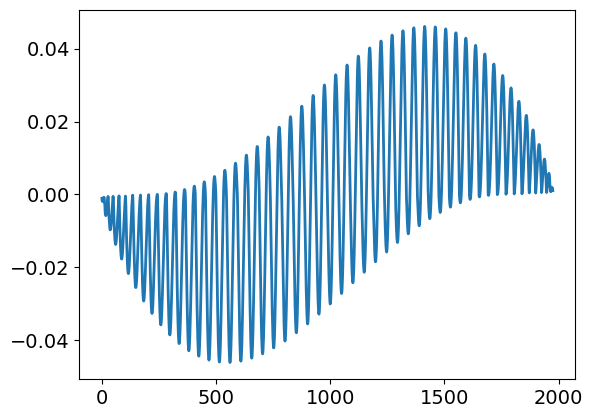

In [24]:
plt.plot(v[:,3])
plt.show()

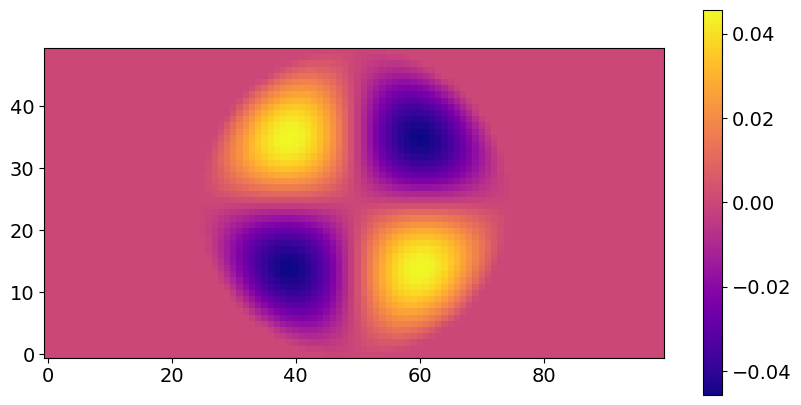

'faire les modes circulaires du djambé'

In [26]:
phi = np.zeros(shape)
phi[G>-1] = v[:,1]
phi[G>-1] == np.nan

plt.figure(figsize = (10,5))
plt.imshow(phi, origin="lower",cmap=  'plasma')
plt.colorbar()
plt.show()

## Part to try things 

In [12]:
#define a circular domain:
def domain(x,y) : 
    """function to define the domain where fluids are"""
    circle = x**2+y**2
    radius = np.sqrt(circle)
    msk = np.ones(shape, dtype="b")
    #there are some fluids inside the circular domain
    msk[x<=radius : y<= radius] = 1
    #there are not fluids outside the domain
    msk[ x>radius : y>radius] = -1
    return msk
d = domain(xxc,yyc)
print(d)
    
f1 = plt.figure()
plt.plot(d)
plt.show()
print(circle)

TypeError: only integer scalar arrays can be converted to a scalar index

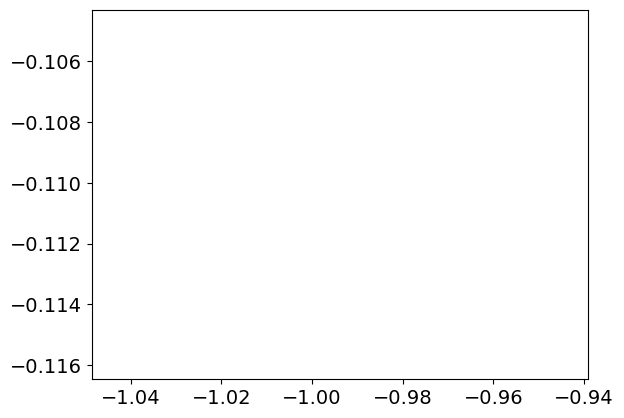

TypeError: slice indices must be integers or None or have an __index__ method

In [13]:
f2 = plt.figure()
plt.plot(np.sin(ny),np.cos(nx))
plt.show()

msk = np.ones(shape, dtype="b")
np.sin(ny)
np.cos(nx)
msk[:np.sin(ny), :np.cos(nx)] = 0

print(msk)

In [14]:
# define msk
msk = np.ones(shape, dtype="b")
msk[((xxc-Lx/2)**2+(yyc-Ly/2)**2)>1] = 0
print(msk)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Try the periodic case

In [10]:
#we have to work on the bondaries condition of the matrix 
"""
#to have a periodic case, we have to impose the same BC at the beginning et at the end of the Matrix
# boundary conditions are A and B -> add them at the begining of the script
A = 1.
B = 1.

# add boundary values
rhs[0] = (rhs[0]+A/dx)/2.
rhs[-1] = (rhs[-1]+B/dx)/2.
"""

'\n#to have a periodic case, we have to impose the same BC at the beginning et at the end of the Matrix\n# boundary conditions are A and B -> add them at the begining of the script\nA = 1.\nB = 1.\n\n# add boundary values\nrhs[0] = (rhs[0]+A/dx)/2.\nrhs[-1] = (rhs[-1]+B/dx)/2.\n'